# Week 2 Assignment: CIFAR-10 Autoencoder

For this week, you will create a convolutional autoencoder for the [CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset. You are free to choose the architecture of your autoencoder provided that the output image has the same dimensions as the input image.

After training, your model should meet loss and accuracy requirements when evaluated with the test dataset. You will then download the model and upload it in the classroom for grading. 

Let's begin!

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential

## Load and prepare the dataset

The [CIFAR 10](https://www.tensorflow.org/datasets/catalog/cifar10) dataset already has train and test splits and you can use those in this exercise. Here are the general steps:

* Load the train/test split from TFDS. Set `as_supervised` to `True` so it will be convenient to use the preprocessing function we provided.
* Normalize the pixel values to the range [0,1], then return `image, image` pairs for training instead of `image, label`. This is because you will check if the output image is successfully regenerated after going through your autoencoder.
* Shuffle and batch the train set. Batch the test set (no need to shuffle).


In [2]:
# preprocessing function
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image # dataset label is not used. replaced with the same image input.

# parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024


### START CODE HERE (Replace instances of `None` with your code) ###

# use tfds.load() to fetch the 'train' split of CIFAR-10
train_dataset = tfds.load('cifar10', as_supervised = True, split = 'train')

# preprocess the dataset with the `map_image()` function above
train_dataset = train_dataset.map(map_image) 

# shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


# use tfds.load() to fetch the 'test' split of CIFAR-10
test_dataset = tfds.load('cifar10', as_supervised = True, split = 'test')

# preprocess the dataset with the `map_image()` function above
test_dataset = test_dataset.map(map_image) 

# batch the dataset
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

### END CODE HERE ###

## Build the Model

Create the autoencoder model. As shown in the lectures, you will want to downsample the image in the encoder layers then upsample it in the decoder path. Note that the output layer should be the same dimensions as the original image. Your input images will have the shape `(32, 32, 3)`. If you deviate from this, your model may not be recognized by the grader and may fail. 

We included a few hints to use the Sequential API below but feel free to remove it and use the Functional API just like in the ungraded labs if you're more comfortable with it. Another reason to use the latter is if you want to visualize the encoder output. As shown in the ungraded labs, it will be easier to indicate multiple outputs with the Functional API. That is not required for this assignment though so you can just stack layers sequentially if you want a simpler solution.

In [3]:
# # suggested layers to use. feel free to add or remove as you see fit.
# from keras.layers import Conv2D, UpSampling2D

# # use the Sequential API (you can remove if you want to use the Functional API)
# model = Sequential()

# ### START CODE HERE ###
# # use `model.add()` to add layers (if using the Sequential API)
# model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
   
# model.add(UpSampling2D())
# model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      
# model.add(UpSampling2D())
# model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      
# model.add(UpSampling2D())
# model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))     


# ### END CODE HERE ###

# model.summary()

In [4]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [5]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [6]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [7]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(32, 32, 3))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

In [10]:
model, encoder_model = convolutional_auto_encoder()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         2950

## Configure training parameters

We have already provided the optimizer, metrics, and loss in the code below.

In [11]:
# Please do not change the model.compile() parameters
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

## Training

You can now use [model.fit()](https://keras.io/api/models/model_training_apis/#fit-method) to train your model. You will pass in the `train_dataset` and you are free to configure the other parameters. As with any training, you should see the loss generally going down and the accuracy going up with each epoch. If not, please revisit the previous sections to find possible bugs.

*Note: If you get a `dataset length is infinite` error. Please check how you defined `train_dataset`. You might have included a [method that repeats the dataset indefinitely](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat).*

In [12]:
# parameters (feel free to change this)
train_steps = len(train_dataset) // BATCH_SIZE 
val_steps = len(test_dataset) // BATCH_SIZE

### START CODE HERE ###
model.fit(train_dataset, validation_data=test_dataset, epochs=5)
### END CODE HERE ###

Epoch 1/5
391/391 [==============================] - 18s 37ms/step - loss: 0.0102 - accuracy: 0.7339 - val_loss: 0.0044 - val_accuracy: 0.8098
Epoch 2/5
391/391 [==============================] - 11s 27ms/step - loss: 0.0040 - accuracy: 0.8086 - val_loss: 0.0034 - val_accuracy: 0.8231
Epoch 3/5
391/391 [==============================] - 11s 27ms/step - loss: 0.0033 - accuracy: 0.8165 - val_loss: 0.0032 - val_accuracy: 0.7990
Epoch 4/5
391/391 [==============================] - 11s 27ms/step - loss: 0.0028 - accuracy: 0.8190 - val_loss: 0.0024 - val_accuracy: 0.8286
Epoch 5/5
391/391 [==============================] - 11s 27ms/step - loss: 0.0024 - accuracy: 0.8223 - val_loss: 0.0022 - val_accuracy: 0.8197


## Model evaluation

You can use this code to test your model locally before uploading to the grader. To pass, your model needs to satisfy these two requirements:

* loss must be less than 0.01 
* accuracy must be greater than 0.6

In [13]:
result = model.evaluate(test_dataset, steps=10)

10/10 [==============================] - 0s 12ms/step - loss: 0.0022 - accuracy: 0.8202


If you did some visualization like in the ungraded labs, then you might see something like the gallery below. This part is not required.

<img src="https://drive.google.com/uc?export=view&id=12Fy-guiP-3tTPfc9IV2nHhqLvs7LwRo6" width="75%" height="75%"/>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def display_one_row(disp_images, offset, shape=(32, 32,3)):
  '''Display sample outputs in one row.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,8)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(32,32,3))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(32,32,3))

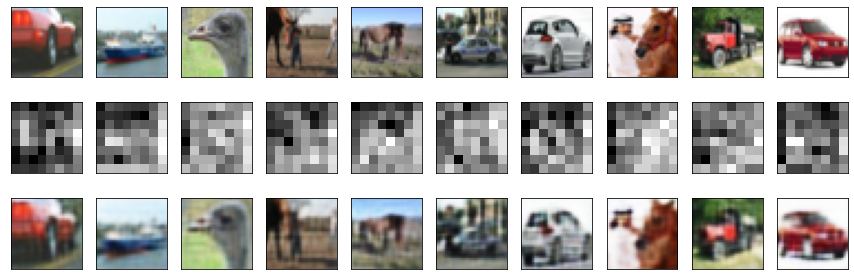

In [17]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 32, 32, 3))

# get the encoder ouput
encoded = encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(8,8))

## Save your model

Once you are satisfied with the results, you can now save your model. Please download it from the Files window on the left and go back to the Submission portal in Coursera for grading.

In [18]:
model.save('mymodel.h5')

**Congratulations on completing this week's assignment!**